My dataset is images of cats and dogs that I will try to cluster together.

Dataset from the validation folder from: https://www.kaggle.com/datasets/kunalgupta2616/dog-vs-cat-images-data/data?select=dogcat. Only using the first 100 cats images and first 100 dogs images to save time.

**1. Apply PCA to the images from different conditions (each folder contains images for one of the conditions: realistic, features, blurred, geons, and silhouettes; you need to apply PCA separately for images in each of the folders).  How many components do you need to preserve at least 95% of the variance in each condition? Why do some conditions require more components than others?  [3 points]**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing images to python done with help of ChatGPT
import os
from PIL import Image

def import_images(folder_path, number_of_imgs):
  image_size = (128, 128) #Resize images to all be the same dimension, PCA doesn't work otherwise
  images = []
  i = 0

  for filename in os.listdir(folder_path):
    if i < number_of_imgs:
      img_path = os.path.join(folder_path, filename)
      img = Image.open(img_path).convert("L")   # convert image to grayscale
      img = img.resize(image_size)
      images.append(np.array(img))
      i += 1
    else:
      break

  images = np.array(images)

  print('Shape before flattening, before PCA:', images.shape)

  X = images.reshape(len(images), -1) #Flatten images to 2d
  #42 images x 16384 pixels for each iamges
  print('Shape after flattening, before PCA:', X.shape)
  return X

In [3]:
from sklearn.decomposition import PCA
#Load the dogs images
X_dogs = import_images('/content/drive/MyDrive/dogs', 100)
X_cats = import_images('/content/drive/MyDrive/cats', 100)

Shape before flattening, before PCA: (100, 128, 128)
Shape after flattening, before PCA: (100, 16384)
Shape before flattening, before PCA: (100, 128, 128)
Shape after flattening, before PCA: (100, 16384)


In [4]:
X_combined = np.concatenate([X_cats, X_dogs], axis = 0)
print('Shape before PCA:', X_combined.shape)
#0 = cats, 1 = dogs
file_type = ['cat'] * 100 + ['dog'] * 100

# Keep 95% of the variance
pca = PCA(n_components = 0.95)
X_pca_combined = pca.fit_transform(X_combined)

# print(pca.explained_variance_ratio_)
print('Shape after PCA:', X_pca_combined.shape)

Shape before PCA: (200, 16384)
Shape after PCA: (200, 109)


You need 109 components to keep 95% of the variance.

**2. Plot 10 realistic images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept at least 95% of the variance using PCA. [3 points]**

In [5]:
X_reconstructed = pca.inverse_transform(X_pca_combined)
X_reconstructed = X_reconstructed.reshape(-1, 128, 128)
# X_reconstructed.shape

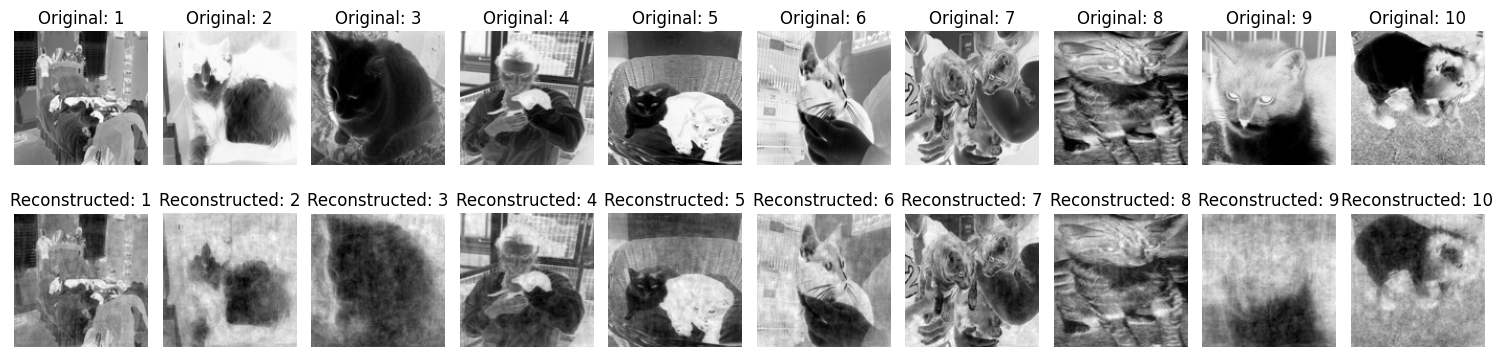

In [6]:
plt.figure(figsize = (15, 4))
original_images = X_combined.reshape(-1, 128, 128)

for i in range(10):
  # Original Realistic Images on the top row
  plt.subplot(2, 10, i+1)
  # Show the original realistic image
  plt.imshow(original_images[i], cmap = 'binary')
  plt.axis('off')
  plt.title(f'Original: {i+1}')

  #Reconstructed Realistic Images on the bottom row
  plt.subplot(2, 10, i+11)
  # Show the reconstructed realistic image
  plt.imshow(X_reconstructed[i], cmap = 'binary')
  plt.axis('off')
  plt.title(f'Reconstructed: {i+1}')

plt.tight_layout()

**3. Each of the images belong to one of 2 clusters (Cats, Dogs). The clusters is indicated by the image name. We will now try to see if the visualization can help us identify different clusters.**

**A. For each condition (folder) use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components for each condition? [3 points].**

In [7]:
# Keep first 2 principal components
pca = PCA(n_components = 2)
X_pca_combined = pca.fit_transform(X_combined)

# Amount of Variance kept by the first two principal components
print(f'{sum(pca.explained_variance_ratio_):.2%}', 'of the variance is explained by the first two prinncipal components for the cat and dog images.')

33.59% of the variance is explained by the first two prinncipal components for the cat and dog images.


**B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image class (so you will have two different colors). Repeat the process and create the same type of plots for t-SNE, LLE and UMAP. [6 points]**

In [8]:
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import umap

def create_dimensionality_df(X, filetypes):
  '''Returns df with first two principal components for PCA, TSNE, LLE, and UMAP along with file type
  for image (car, chair, cup, etc...)'''
  #Put everything into a df
  pca = PCA(n_components = 2)
  X_pca= pca.fit_transform(X)
  dimensionality_df = pd.DataFrame(X_pca, columns = ['PC1', 'PC2'])

  # Apply t-SNE to X
  tsne = TSNE(n_components=2, random_state=42) # Set random_state for reproducibility
  X_tsne = tsne.fit_transform(X)
  #Add it to the df
  dimensionality_df['TSNE1'] = X_tsne[:, 0]
  dimensionality_df['TSNE2'] = X_tsne[:, 1]

  # Apply LLE to X
  lle = LocallyLinearEmbedding(n_components=2, random_state=42)
  X_lle = lle.fit_transform(X)
  #Add it to the df
  dimensionality_df['LLE1'] = X_lle[:, 0]
  dimensionality_df['LLE2'] = X_lle[:, 1]

  # Apply UMAP to X
  reducer = umap.UMAP(n_components=2, random_state=42)
  X_umap = reducer.fit_transform(X)
  #Add it to the df
  dimensionality_df['UMAP1'] = X_umap[:, 0]
  dimensionality_df['UMAP2'] = X_umap[:, 1]

  dimensionality_df['file_type'] = filetypes

  return dimensionality_df

In [9]:
combined_df = create_dimensionality_df(X_combined, file_type)
combined_df.head()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,PC1,PC2,TSNE1,TSNE2,LLE1,LLE2,UMAP1,UMAP2,file_type
0,1892.189397,-606.777603,-4.172653,-1.586750,-0.062730,0.017939,7.229905,4.193154,cat
1,-7587.807111,1709.238805,6.941130,-3.218948,0.111180,0.022569,7.424964,0.171836,cat
2,5044.762927,7246.150519,-7.425145,-2.261776,-0.027764,-0.044136,5.961718,5.383339,cat
3,1295.767393,3726.135679,0.247534,2.240597,-0.007384,-0.113092,6.039233,3.266585,cat
4,2580.934273,-1778.872295,-3.299853,-4.442882,-0.031924,0.038642,7.862417,3.814132,cat


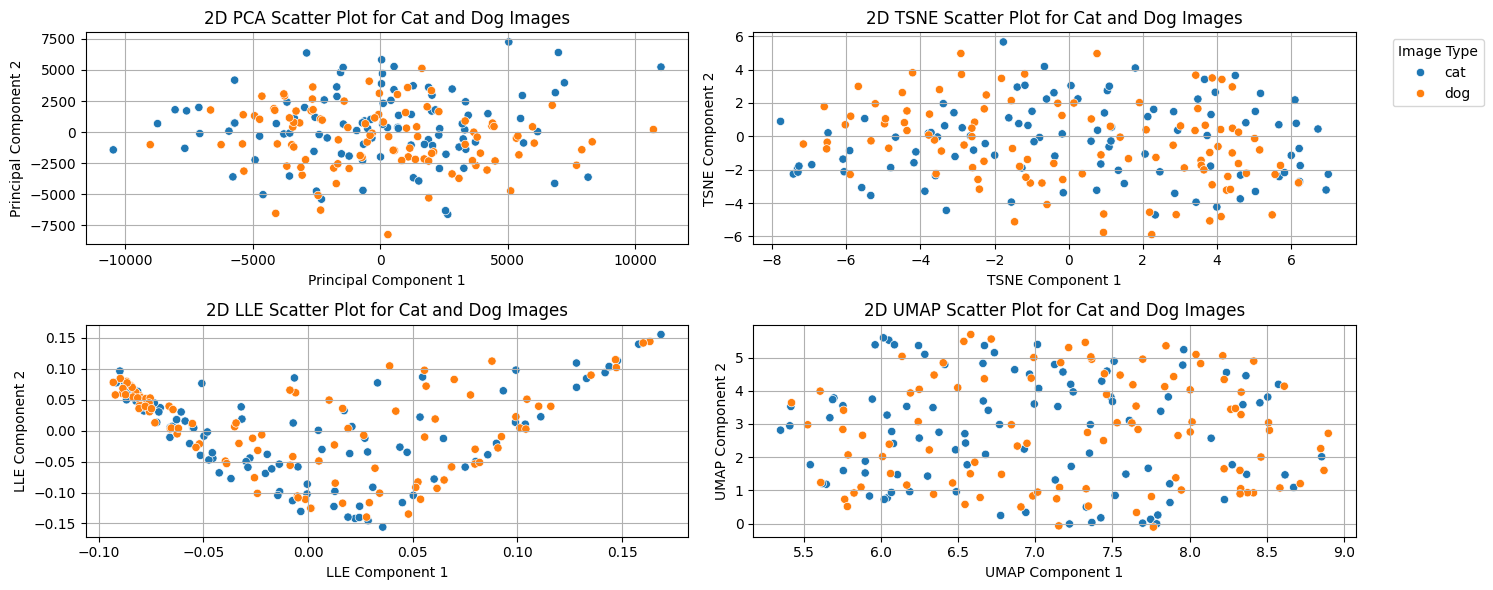

In [10]:
# Scatterplots created with help of ChatGPT

#Scatterplots for Cat and Dog Images
plt.figure(figsize=(15, 6))

#PCA subplot
plt.subplot(2, 2, 1)
sns.scatterplot(data=combined_df, x='PC1', y='PC2', hue='file_type', legend = False)
plt.title('2D PCA Scatter Plot for Cat and Dog Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

#TSNE subplot
plt.subplot(2, 2, 2)
sns.scatterplot(data=combined_df, x='TSNE1', y='TSNE2', hue='file_type')
plt.title('2D TSNE Scatter Plot for Cat and Dog Images')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Image Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

#LLE subplot
plt.subplot(2, 2, 3)
sns.scatterplot(data=combined_df, x='LLE1', y='LLE2', hue='file_type', legend = False)
plt.title('2D LLE Scatter Plot for Cat and Dog Images')
plt.xlabel('LLE Component 1')
plt.ylabel('LLE Component 2')
plt.grid(True)

#UMAP subplot
plt.subplot(2, 2, 4)
sns.scatterplot(data=combined_df, x='UMAP1', y='UMAP2', hue='file_type', legend = False)
plt.title('2D UMAP Scatter Plot for Cat and Dog Images')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)

plt.tight_layout()
plt.show()

**4. Cluster the images using KMeans.**

**A. To make the process faster, reduce the dimensionality using PCA, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class, suitable for the K-means algorithm. [2 points]**

In [11]:
#Need to feature scaling for Kmeans to perform well
from sklearn.preprocessing import StandardScaler

# Standardize raw features
scaler1 = StandardScaler()
X_combined_scaled = scaler1.fit_transform(X_combined)

#Reduce variance to 95% using PCA
pca_95 = PCA(n_components = 0.95)

X_pca_combined = pca_95.fit_transform(X_combined_scaled)

#Number of dimensions kept for each condition (2nd number)
print(X_pca_combined.shape)

(200, 109)


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_sil_scores(X):
  silhouette_scores = []

  for i in range(2, 13):
    #Initialize KMeans using i number of clusters
    kmeans = KMeans(n_clusters = i, n_init = 20, random_state = 42)
    #Predict the cluster for each instance
    cluster_labels = kmeans.fit_predict(X)
    #Calculate the silhouette score
    current_silhouette_score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(current_silhouette_score)
  return silhouette_scores

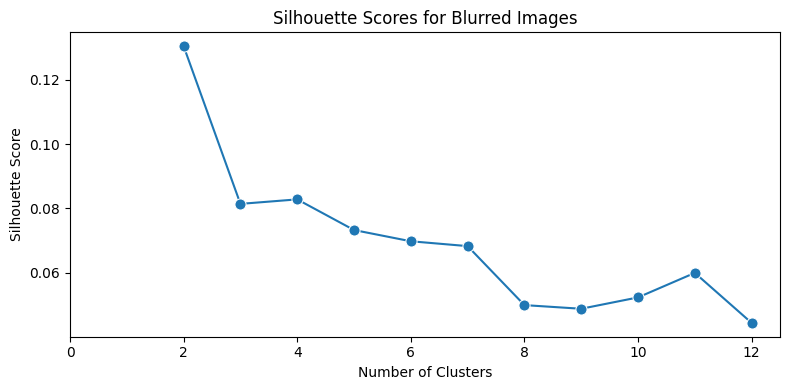

In [13]:
plt.figure(figsize = (8, 4))
clusters = list(range(2, 13))

#Number of clusters on x-axis, silhouette score for that number of clusters on the y-axis
sns.lineplot(x= clusters , y= get_sil_scores(X_pca_combined), marker='o', markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Blurred Images')
plt.xticks(np.arange(0, 13, 2));

plt.tight_layout()
plt.show()

Optimal Number of Clusters based on the Highest Silhouette Score is 2.

**B. Set the number of clusters to 2 (ground truth), report clustering accuracy (choose an appropriate mapping) and show a confusion matrix. [3 points]**

In [14]:
#Mapping of file type to discrete integer
file_type_to_int_dict = {"cat": 0, "dog": 1}
# Reverse mapping of discrete integers to file type
file_type_int_to_string_dict = {0:'cat', 1:'dog'}

In [15]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

#Done with help of ChatGPT
def get_optimized_confusion_matrix(y_true, y_pred):
    """
    Computes clustering accuracy and returns components for visualization,
    assuming y_true and y_pred are numerical arrays.
    """
    # 1. Create the Contingency Matrix
    C = confusion_matrix(y_true, y_pred)

    # 2. Apply the Hungarian Algorithm
    # col_ind contains the optimal predicted cluster index for each true label row_ind
    row_ind, col_ind = linear_sum_assignment(C.max() - C)

    # 3. Calculate Accuracy
    accuracy = C[row_ind, col_ind].sum() / y_true.size

    # 4. Generate Class Names (based on unique values in y_true)
    unique_classes = np.unique(y_true)
    true_labels = [f"{file_type_int_to_string_dict[i]}" for i in unique_classes]

    # Return the accuracy, initial matrix, true label names, and the optimal mapping
    return accuracy, C, true_labels, col_ind

Clustering Accuracy for Cat and Dog Images: 51.50%


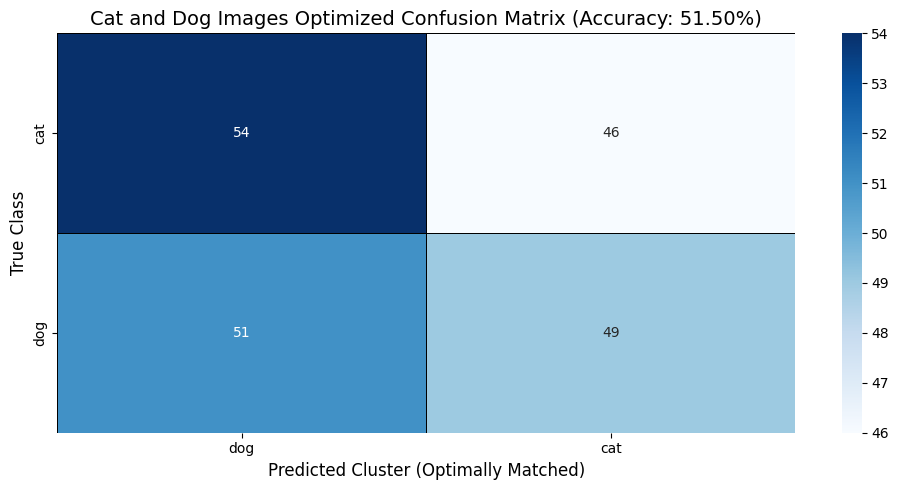

In [16]:
#Cat and Dog Images

#Initialize 2 clusters with 95% variance PCA
kmeans = KMeans(n_clusters = 2, n_init = 20, random_state = 42)
kmeans.fit(X_pca_combined)

# Convert file types to discrete integers - Ex: "cat" -> 0, "dog" -> 1
combined_file_types_int = [file_type_to_int_dict[file_type] for file_type in file_type]

#Find components for finding cluster accuracy using Hungarian Algorithm
accuracy, C_initial, true_labels, optimal_map = get_optimized_confusion_matrix(
    np.array(combined_file_types_int), kmeans.labels_)

# Re-order the columns in the way that maximizes accuracy according to Hungarian Algorithm
C_optimized = C_initial[:, optimal_map]

# Convert names from predicting cluster 0 to predicted cluster "airplane"
predicted_labels = [f"{file_type_int_to_string_dict[i]}" for i in optimal_map]

# 3. Create DataFrame for plotting
cm_df = pd.DataFrame(C_optimized, index=true_labels, columns=predicted_labels)
print(f"Clustering Accuracy for Cat and Dog Images: {accuracy:.2%}")

# # --- Visualization ---
plt.figure(figsize=(10, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)
plt.title(f'Cat and Dog Images Optimized Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Cluster (Optimally Matched)', fontsize=12)
plt.tight_layout()
plt.show() # In a notebook environment, this displays the plot

Only get slightly over 50% accuracy for KMeans clustering, KMeans must have a hard time clustering cats and dogs only using there 95% variance PCA's.

**C. Repeat step B, but instead of features derived using PCA, use features obtained with a pretrained ResNet model - use penultimate layer (size of the ResNet model and data used for pretraining are up to you; note that you will need to resize images to 224×224 for ResNet). [3 points]**

Gets features from penultimate layer of resnet18

In [17]:
import torch
import torch.nn as nn
from torchvision import models, transforms

#Load the model, trained on imagenet dataset
#Create with help of ChatGPT and resnet18 documentation: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove last classification layer to get penultimate features
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
#ensures that the extracted features are stable and deterministic, not noisy
feature_extractor.eval()

# For ImageNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), #Resize to 224 by 224 - needed for Resnet18
    transforms.ToTensor(), #Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], #Resnet18 was trained using images normalized with this means and stdevs for RGB values
        std=[0.229, 0.224, 0.225]
    ),
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [18]:
def import_images_resnet(folder_path, number_of_imgs):
  #Imports images for resnet
  images = []
  i = 0

  for filename in os.listdir(folder_path):
    if i < number_of_imgs:
      img_path = os.path.join(folder_path, filename)
      img = Image.open(img_path).convert("RGB")   # Resnet18 expects images to be in RGB format, not grayscale
      #Preprocess images
      img = preprocess(img)
      images.append(img)
      i = i + 1
    else:
      break

  images = torch.stack(images)  # Stack into a single tensor of shape (N, C, H, W)
  print('Shape of images tensor:', images.shape)

  #Feed images into neural network and get penultimate layer features
  with torch.no_grad():  # Disable gradient computation (faster & less memory)
    features = feature_extractor(images)  # Output shape: (N, 512, 1, 1)

  #Flatten penultimate layer output
  features = features.view(features.size(0), -1)  # Shape: (N, 512)
  #Convert to numpy array for KMeans, doesn't work with tensor
  features = features.numpy()
  print('Shape of extracted features:', features.shape)
  return features

In [19]:
#Get features from penultimate layer of resnet18 trained on imagenet dataset (everyday objects and animals)
X_cats_resnet = import_images_resnet('/content/drive/MyDrive/cats', 100)
X_dogs_resnet = import_images_resnet('/content/drive/MyDrive/dogs', 100)

Shape of images tensor: torch.Size([100, 3, 224, 224])
Shape of extracted features: (100, 512)
Shape of images tensor: torch.Size([100, 3, 224, 224])
Shape of extracted features: (100, 512)


Clustering Accuracy for Cat and Dog Images: 92.00%


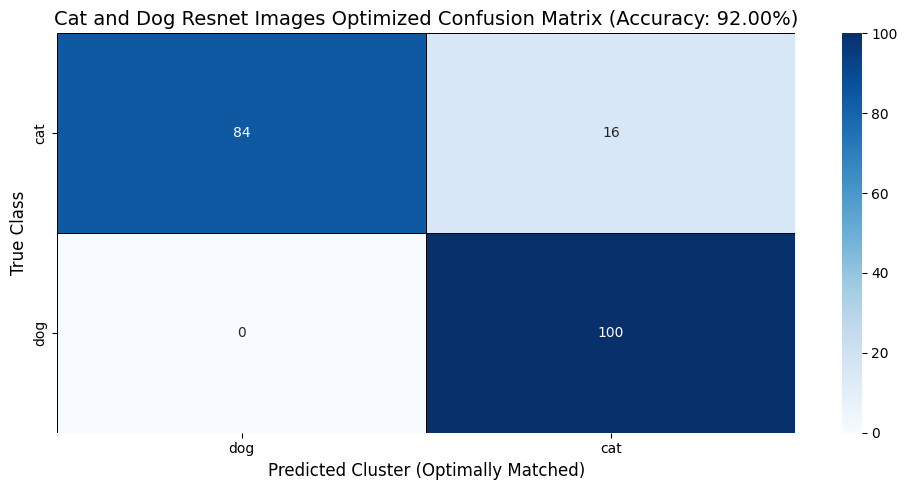

In [20]:
X_combined_resnet = np.concatenate([X_cats_resnet, X_dogs_resnet], axis = 0)

#Cat and Dog Images

#Initialize 2 clusters with 95% variance PCA
kmeans = KMeans(n_clusters = 2, n_init = 20, random_state = 42)
kmeans.fit(X_combined_resnet)

# Convert file types to discrete integers - Ex: "cat" -> 0, "dog" -> 1
combined_file_types_int = [file_type_to_int_dict[file_type] for file_type in file_type]

#Find components for finding cluster accuracy using Hungarian Algorithm
accuracy, C_initial, true_labels, optimal_map = get_optimized_confusion_matrix(
    np.array(combined_file_types_int), kmeans.labels_)

# Re-order the columns in the way that maximizes accuracy according to Hungarian Algorithm
C_optimized = C_initial[:, optimal_map]

# Convert names from predicting cluster 0 to predicted cluster "airplane"
predicted_labels = [f"{file_type_int_to_string_dict[i]}" for i in optimal_map]

# 3. Create DataFrame for plotting
cm_df = pd.DataFrame(C_optimized, index=true_labels, columns=predicted_labels)
print(f"Clustering Accuracy for Cat and Dog Images: {accuracy:.2%}")

# # --- Visualization ---
plt.figure(figsize=(10, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)
plt.title(f'Cat and Dog Resnet Images Optimized Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Cluster (Optimally Matched)', fontsize=12)
plt.tight_layout()
plt.show() # In a notebook environment, this displays the plot

The KMeans clustering using the penultimate layer features from resnet18 works significantly better compared to KMeans clustering for the cat and dog images.

**5. Cluster using EM.**

**A. Reduce again the dimensionality using PCA, but keep at least 95% of the variance. Determine the number of clusters using one of the techniques we discussed in class, suitable for the EM algorithm. [2 points]**

In [21]:
from sklearn.mixture import GaussianMixture

#Model with the lowest BIC has the appropriate number of clusters
def get_bic(X):
  #Get BIC's given number of clusters
  bic_list = []

  for i in range(2, 13):
    #Create Gaussian Mixture Model
    gm = GaussianMixture(n_components=i, n_init = 20, random_state=42).fit(X)
    bic_list.append(float(f'{gm.bic(X):.2f}'))
  return bic_list

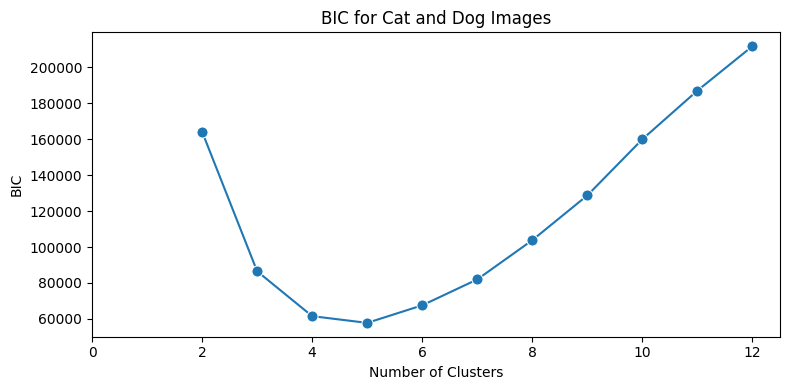

In [22]:
plt.figure(figsize = (8, 4))
clusters = list(range(2, 13))

#Number of clusters on x-axis, BIC for that number of clusters on the y-axis
sns.lineplot(x= clusters , y= get_bic(X_pca_combined), marker='o', markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC for Cat and Dog Images')
plt.xticks(np.arange(0, 13, 2));

plt.tight_layout()
plt.show()

Optimal Number of Clusters for Cat and Dog Images based on the lowest BIC: 5

**B. Set the number of clusters to 2 (ground truth), report clustering accuracy (choose an appropriate mapping) and show a confusion matrix. [3 points]**

Clustering Accuracy for Cat and Dog Images: 51.50%


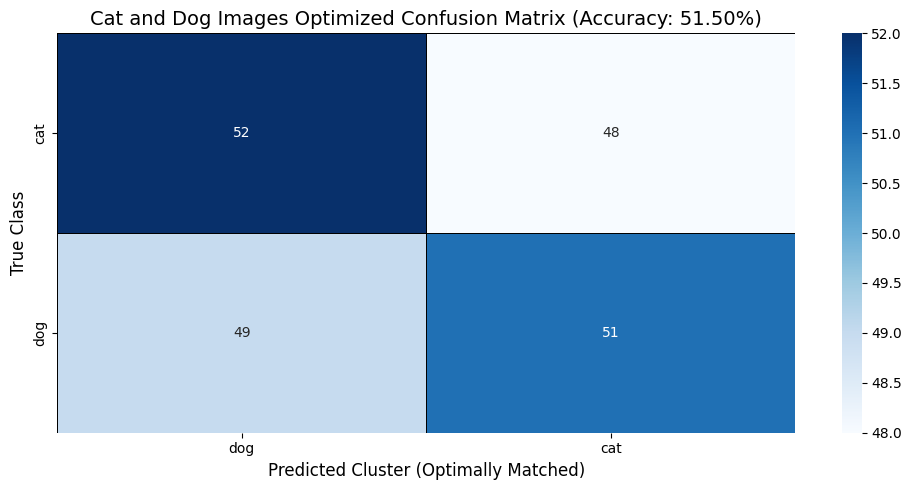

In [23]:
#Cat and Dog Images

#Initialize 2 clusters with 95% variance PCA
gm = GaussianMixture(n_components = 2, n_init = 20, random_state = 42)
gm.fit(X_pca_combined)
gm_pred = gm.predict(X_pca_combined)

# Convert file types to discrete integers - Ex: "airplane" -> 0, "car" -> 1, etc...
combined_file_types_int = [file_type_to_int_dict[file_type] for file_type in file_type]

#Find components for finding cluster accuracy using Hungarian Algorithm
accuracy, C_initial, true_labels, optimal_map = get_optimized_confusion_matrix(
    np.array(combined_file_types_int), gm_pred)

# Re-order the columns in the way that maximizes accuracy according to Hungarian Algorithm
C_optimized = C_initial[:, optimal_map]

# Convert names from predicting cluster 0 to predicted cluster "airplane"
predicted_labels = [f"{file_type_int_to_string_dict[i]}" for i in optimal_map]

# 3. Create DataFrame for plotting
cm_df = pd.DataFrame(C_optimized, index=true_labels, columns=predicted_labels)
print(f"Clustering Accuracy for Cat and Dog Images: {accuracy:.2%}")

# # --- Visualization ---
plt.figure(figsize=(10, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)
plt.title(f'Cat and Dog Images Optimized Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Cluster (Optimally Matched)', fontsize=12)
plt.tight_layout()
plt.show() # In a notebook environment, this displays the plot

EM doesn't do a good job of classifying cat and dog images. Only slightly above 50%.

**C. Use the model to generate 5 new images for each condition (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).  [4 points]**

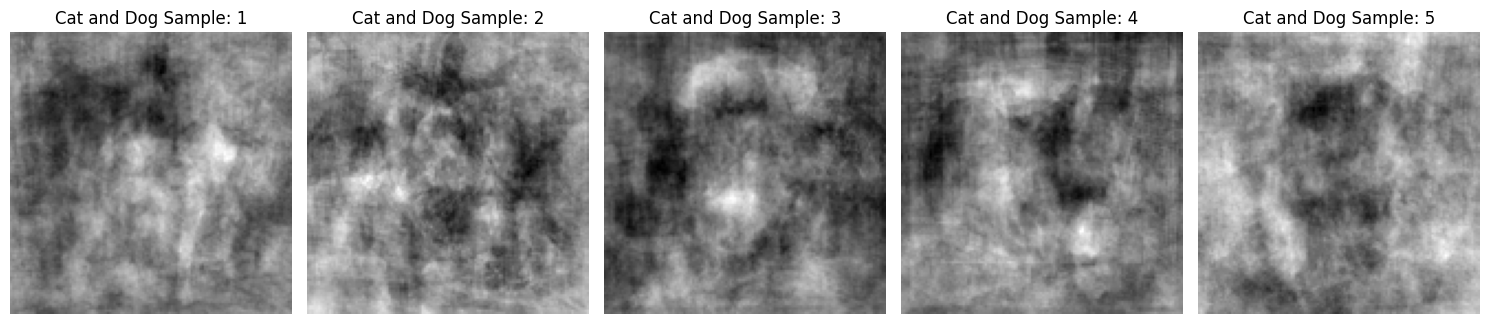

In [24]:
#Cat and Dog images
gm = GaussianMixture(n_components = 2, n_init = 20, random_state = 42)
gm.fit(X_pca_combined)

#Sample 5 Cat and Dog Images
#Only need the first returned value of the tuple
X_pca_combined_sample = gm.sample(5)[0]
#Inverse transform to get all pixels
X_combined_sample_reconstructed = pca_95.inverse_transform(X_pca_combined_sample)
#Reshape to 128 by 128 image/unflaten
X_reconstructed = X_combined_sample_reconstructed.reshape(-1, 128, 128)

plt.figure(figsize = (15, 4))
for i, current_image in enumerate(X_reconstructed):
  plt.subplot(1, 5, i + 1)
  # Show the sampled and reconstructed image
  plt.imshow(current_image, cmap = 'binary')
  plt.axis('off')
  plt.title(f'Cat and Dog Sample: {i+1}')

plt.tight_layout()

**D. Repeat step B, but instead of features derived using PCA, use features obtained with a pretrained ResNet model. [3 points]**

Clustering Accuracy for Cat and Dog Images: 94.00%


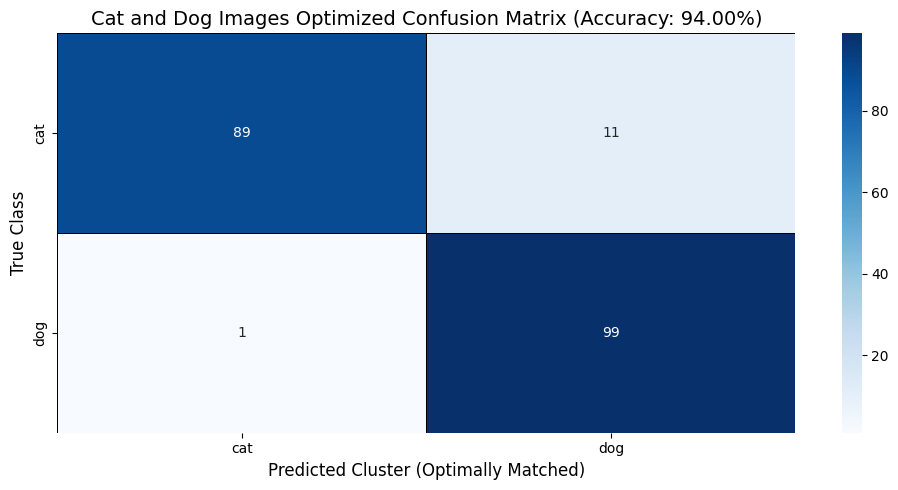

In [25]:
#Resnet preprocessing still saved

#Cat and Dog Images

#Initialize 8 clusters with 95% variance PCA
gm = GaussianMixture(n_components = 2, n_init = 20, random_state = 42)
gm.fit(X_combined_resnet)
gm_pred = gm.predict(X_combined_resnet)

# Convert file types to discrete integers - Ex: "airplane" -> 0, "car" -> 1, etc...
combined_file_types_int = [file_type_to_int_dict[file_type] for file_type in file_type]

#Find components for finding cluster accuracy using Hungarian Algorithm
accuracy, C_initial, true_labels, optimal_map = get_optimized_confusion_matrix(
    np.array(combined_file_types_int), gm_pred)

# Re-order the columns in the way that maximizes accuracy according to Hungarian Algorithm
C_optimized = C_initial[:, optimal_map]

# Convert names from predicting cluster 0 to predicted cluster "airplane"
predicted_labels = [f"{file_type_int_to_string_dict[i]}" for i in optimal_map]

# 3. Create DataFrame for plotting
cm_df = pd.DataFrame(C_optimized, index=true_labels, columns=predicted_labels)
print(f"Clustering Accuracy for Cat and Dog Images: {accuracy:.2%}")

# # --- Visualization ---
plt.figure(figsize=(10, 5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    linewidths=0.5,
    linecolor='black'
)
plt.title(f'Cat and Dog Images Optimized Confusion Matrix (Accuracy: {accuracy:.2%})', fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Cluster (Optimally Matched)', fontsize=12)
plt.tight_layout()
plt.show() # In a notebook environment, this displays the plot

The EM clustering using the penultimate layer features from resnet18 works significantly better for clustering cat and dog images.